<h1> Challenge DE </h1>

In [1]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random
import folium
%load_ext memory_profiler

<h2> Pregunta 1 </h2>
Agrupar datos similares

In [2]:
# Leer datos
data = pd.read_csv (r'trips.csv')   
df = pd.DataFrame(data)

En primer lugar, visualizamos los datos para ver cómo se distribuyen geográficamente.

In [47]:
# Agrupar por origen de coordenadas

# Guardar una nueva columna con las coordenadas por separado

origin_x = []
origin_y = []
dest_x  = []
dest_y = []

# Crear una nueva columna con las horas de viaje (sin fecha)
times = []
# Crear una nueva columna con el horario: mañana, tarde, noche
schedule = []
early_morning = datetime.strptime('06:00:00', '%H:%M:%S').time()
noon = datetime.strptime('12:00:00', '%H:%M:%S').time()
evening = datetime.strptime('18:00:00', '%H:%M:%S').time()
# Crear nuevo mapa
map_new = folium.Map()

i = 0
for row in df.itertuples():
    # Origen
    origin = row.origin_coord.split()
    x = origin[1][1:]
    y = origin[2][:-1]
    origin_x.append(x)
    origin_y.append(y)
    map_new.add_child(folium.Marker([y,x],popup=str(i), icon=folium.Icon(color='red')))
    # Destino
    destination = row.destination_coord.split()
    x = destination[1][1:]
    y = destination[2][:-1]  
    dest_x.append(x)
    dest_y.append(y)
    map_new.add_child(folium.Marker([y,x],popup=str(i), icon=folium.Icon(color='green')))
    # Horario
    date_time = row.datetime.split()
    time = datetime.strptime(date_time[1], '%H:%M:%S').time()
    times.append(date_time[1])
    # Chequear si es mañana, tarde o noche
    if (time < early_morning):
        schedule.append('Early Morning')    
    elif (time < noon):
        schedule.append('Morning')
    elif (time < evening):
        schedule.append('Afternoon')
    else:
        schedule.append('Evening')
    i+=1
    
# Mostrar mapa 
map_new

Se puede notar que la mejor manera de agruparlos corresponde a la región, información que ya viene incluida en el archivo csv.
A continuación, vemos si existe alguna tendencia en los horarios de los viajes a través de un histograma, el cual diferencia entre: 'Early Morning' (00:00 a 06:00 horas), 'Morning' (06:00 a 12:00), 'Afternoon' (12:00 a 18:00) y 'Evening' (18:00 a 00:00).

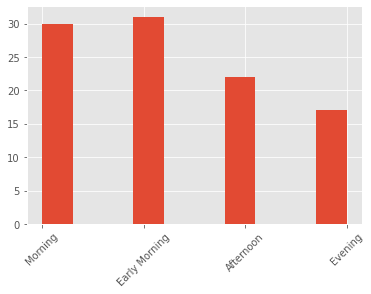

In [49]:
# Crear histograma con los horarios
plt.style.use('ggplot')
plt.hist(schedule)
plt.xticks(rotation = 45)
plt.show()

Al agrupar por viajes, se puede notar que la mayoría de estos son entre 00:00 y 12:00 horas.

<h2> Pregunta 2 </h2>
<h3> Parte a </h3>
Servicio que devuelve el promedio semanal de la cantidad de viajes para un área definida por un bounding box y la región

Primero se crea las funciones necesarias para conectarse al servidor, crear la base de datos y las todas las tablas necesarias.

In [5]:
# Conectarse a la BD SQL

def create_server_connection(host_name, user_name, user_password):
    connection = None
    try:
        # Intentar crear conexión
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password
        )
        print("Conexión exitosa")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

db = 'travels'
pw = '*****'
connection = create_server_connection("localhost", "root", pw)

Conexión exitosa


In [6]:
# Crear nueva base de datos

def create_database(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Base de datos creada exitosamente")
    except Error as err:
        print(f"Error: '{err}'")

create_database_query = "CREATE DATABASE " + db
create_database(connection, create_database_query)

Base de datos creada exitosamente


In [7]:
# Crear conexión a la base de datos

def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("Conexión a la base de datos exitosa")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [8]:
# Ejecución de una query

def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
    except Error as err:
        print(f"Error: '{err}'")

Se decide crear tres tablas: regiones (region), fuente de los datos (source) y los viajes propiamente tal (travel).

In [9]:
# Crear tablas para regiones y fuentes de datos
create_region_table = """
CREATE TABLE region (
  region_id INT PRIMARY KEY AUTO_INCREMENT,
  region_name VARCHAR(40) NOT NULL
  );
 """

create_source_table = """
CREATE TABLE source (
  source_id INT PRIMARY KEY AUTO_INCREMENT,
  source_name VARCHAR(40) NOT NULL
  );
 """

connection = create_db_connection("localhost", "root", pw, db)
execute_query(connection, create_region_table) 
execute_query(connection, create_source_table) 

Conexión a la base de datos exitosa


In [10]:
# Crear tabla para viajes
create_travel_table = """
CREATE TABLE travel (
  travel_id INT PRIMARY KEY AUTO_INCREMENT,
  origin GEOMETRY NOT NULL,
  destination GEOMETRY NOT NULL,
  datetime DATETIME NOT NULL,
  region_id INT,
  source_id INT
  );
 """

connection = create_db_connection("localhost", "root", pw, db) 
execute_query(connection, create_travel_table) 

Conexión a la base de datos exitosa


In [11]:
# Añadir foreign keys a tabla de viajes
alter_travel_1 = """
ALTER TABLE travel
ADD FOREIGN KEY(region_id)
REFERENCES region(region_id)
ON DELETE SET NULL;
"""

alter_travel_2 = """
ALTER TABLE travel
ADD FOREIGN KEY(source_id)
REFERENCES source(source_id)
ON DELETE SET NULL;
"""

connection = create_db_connection("localhost", "root", pw, db) 
execute_query(connection, alter_travel_1) 
execute_query(connection, alter_travel_2) 

Conexión a la base de datos exitosa


In [12]:
# Ejecutar query y obtener resultado
def fetch_one(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        result = cursor.fetchone()
        connection.commit()
        return result
    except Error as err:
        print(f"Error: '{err}'")

Luego, se completan las tablas de regiones y fuentes.

In [13]:
# Llenar las tablas con datos

# Completar tabla con regiones
regions = ['Prague', 'Turin', 'Hamburg'] # Conocemos regiones por el análisis previo
dict_regions = dict()
for region in regions:
    insert_value = """
                    INSERT INTO region (region_name) VALUES
                    ('"""+region+"""');
                    """   
    execute_query(connection, insert_value)  
    check = """
        SELECT region_id FROM region WHERE region.region_name ='"""+ region+"""';
        """
    region_id = fetch_one(connection, check)
    dict_regions[region] = region_id[0]

# Completar tabla con fuentes
sources = ['funny_car', 'baba_car', 'cheap_mobile', 'bad_diesel_vehicles', 'pt_search_app'] # Conocemos fuentes de datos por el análisis previo
dict_sources = dict()
for source in sources:
    insert_value = """
                    INSERT INTO source (source_name) VALUES
                    ('"""+source+"""');
                    """   
    execute_query(connection, insert_value)    
    check = """
            SELECT source_id FROM source WHERE source.source_name ='"""+ source+"""';
            """    
    source_id = fetch_one(connection, check)
    dict_sources[source] = source_id[0]

Finalmente, usando la información contenida en el archivo csv, se completa la base de datos de viajes. Cabe destacar que el archivo se lee en *chunks* de manera de evitar problemas de memoria.

In [14]:
# Función para subir la información del archivo csv a la base de datos

def upload_csv_to_db(filename, connection, chunksize):
    # Recorrer el archivo en chunks, para así no tener problemas de memoria
    for chunk in pd.read_csv(r'trips.csv', chunksize=chunksize):
        df = pd.DataFrame(chunk)
        for row in df.itertuples():

            # Obtener id de la región
            region_id = dict_regions[row.region]

            # Obtener id de la fuente
            source_id = dict_sources[row.datasource]

            # Insertar nuevo viaje
            origin = row.origin_coord
            origin_point = origin.split()[0] + origin.split()[1] + " " + origin.split()[2]
            destination = row.destination_coord
            destination_point = destination.split()[0] + destination.split()[1] + "," + destination.split()[2]    
            origin_point = "ST_GeomFromText('" + origin +"')"
            destination_point = "ST_GeomFromText('" + destination +"')"
            insert_new_travel = "INSERT INTO travel (origin,  destination,  datetime,  region_id,  source_id) VALUES (" + origin_point + ", " + destination_point + ", '" + row.datetime + "'," + str(region_id) + "," + str(source_id) + ");"
            execute_query(connection, insert_new_travel)   
    

In [15]:
%memit
# Conectarse a la BD
connection = create_db_connection("localhost", "root", pw, db)
chunksize = 1000000
upload_csv_to_db(r'trips.csv', connection, chunksize)

peak memory: 131.95 MiB, increment: 0.05 MiB
Conexión a la base de datos exitosa


A continuación, se crea las funciones necesarias para entregar el servicio de promedio semanal de viajes dado un bounding box y una región.

In [16]:
def fetch_many(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")

In [17]:
# Entrega todos los viajes de origen 
def get_bb_origin(bx_1, bx_2, by_1, by_2, region):
    bx_1 = str(bx_1)
    bx_2 = str(bx_2)
    by_1 = str(by_1)
    by_2 = str(by_2)  

    create_polygon = "SET @polygon = ST_GeomFromText('POLYGON((" + bx_1 + " " + by_1 + ", "+ bx_2 + " " + by_1 + ", " + bx_2 + " " + by_2 + ", " + bx_1 + " " + by_2 + ", " + bx_1 + " " + by_1 + "))');"

    get_origin_within_polygon = "SELECT travel_id, ST_AsText(origin), ST_AsText(destination), datetime, region_name, source_name FROM travel B LEFT JOIN region A ON B.region_id = A.region_id LEFT JOIN source C ON B.source_id = C.source_id WHERE ST_Contains(@polygon,origin) AND region_name = '" + region + "'  ORDER BY datetime;"

    connection = create_db_connection("localhost", "root", pw, db) 
    execute_query(connection, create_polygon) 
    result = fetch_many(connection, get_origin_within_polygon)      
    return result

# Entrega todos los viajes de destino 
def get_bb_destination(bx_1, bx_2, by_1, by_2, region):
    bx_1 = str(bx_1)
    bx_2 = str(bx_2)
    by_1 = str(by_1)
    by_2 = str(by_2)   

    create_polygon = "SET @polygon = ST_GeomFromText('POLYGON((" + bx_1 + " " + by_1 + ", "+ bx_2 + " " + by_1 + ", " + bx_2 + " " + by_2 + ", " + bx_1 + " " + by_2 + ", " + bx_1 + " " + by_1 + "))');"

    get_origin_within_polygon = "SELECT travel_id, ST_AsText(origin), ST_AsText(destination), datetime, region_name, source_name FROM travel B LEFT JOIN region A ON B.region_id = A.region_id LEFT JOIN source C ON B.source_id = C.source_id WHERE ST_Contains(@polygon,destination) AND region_name = '" + region + "' ORDER BY datetime;"

    connection = create_db_connection("localhost", "root", pw, db) 
    execute_query(connection, create_polygon) 
    result = fetch_many(connection, get_origin_within_polygon)     
    return result

In [18]:
# Crear un dataframe a partir de una lista
def df_from_list(original_list):
    from_db = []

    for l in original_list:
      from_db.append(list(l))

    columns = ["index", "origin", "dest", "datetime", "region", "source"]
    df = pd.DataFrame(from_db, columns=columns)
    return df

In [19]:
# Obtener promedio semanal de viajes
def get_average_per_week(df):
    # Revisar el caso en que no hay viajes para esa bounding box
    if df["datetime"].count() == 0:
        return 0
    # Obtener los lunes de las dos primeras semanas
    first_date = df["datetime"][0]
    first_monday = first_date - timedelta(days = first_date.weekday())
    second_monday = first_monday + timedelta(days=7)
    # Obtener último domingo
    last_date = df["datetime"][len(df["datetime"])-1]
    last_sunday = last_date + timedelta(days=7-last_date.weekday())

    weeks = 0
    count = 0
    while second_monday < last_sunday:
    #     Revisar quienes están en esa semana (entre ambos lunes)
        condition1 = first_monday <= df["datetime"] 
        condition2 = second_monday > df["datetime"]
        count += ((condition1 & condition2).value_counts().loc[True])
        weeks += 1
        first_monday += timedelta(days=7)
        second_monday += timedelta(days=7)

    return count/weeks

In [20]:
def get_average_from_bb_and_region(bx_1, bx_2, by_1, by_2, region):
    try:
        # Obtener todos los datos ubicados en el bb y la región
        bb_result_origin = get_bb_origin(bx_1, bx_2, by_1, by_2, region)
        bb_result_destination = get_bb_destination(bx_1, bx_2, by_1, by_2, region)
        # Pasar listas a dataframes
        df_origin = df_from_list(bb_result_origin)
        df_dest = df_from_list(bb_result_destination)
        # Obtener promedios tanto para el origen como para el destino
        origin = get_average_per_week(df_origin)
        dest = get_average_per_week(df_dest)
        return {'origin': origin, 'destination': dest}
    except Error as err:
        print(f"No hay viajes en el bounding box y área elegidos")

Se puede observar un ejemplo para la región *Turin* y un bounding box definido por las coordenadas [7.5, 7.6] en x y [40, 51] en y.

In [21]:
%memit
# Ejemplo

bx_1 = 7.5
bx_2 = 7.6
by_1 = 40
by_2 = 51
region = 'Turin'

print(get_average_from_bb_and_region(bx_1, bx_2, by_1, by_2, region))

peak memory: 128.21 MiB, increment: 0.00 MiB
Conexión a la base de datos exitosa
Conexión a la base de datos exitosa
{'origin': 4.333333333333333, 'destination': 3.0}


<h2> Pregunta 3</h2>
<h3> Pruebas de Escalabilidad </h3>
Para probar el funcionamiento con 100 millones de entradas, generamos un archivo con esa cantidad de líneas y lo subimos a la base de datos

In [22]:
# Generar una fecha random entre dos fechas
def generate_random_date(start, end):
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = random.randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [23]:
# Generar línea random de archivo
def generate_row():
    
    # Región random entre las regiones que ya tenemos
    region = random.choice(list(dict_regions.keys()))
    source = random.choice(list(dict_sources.keys()))

    # Coordenadas random de origen
    x = str(random.randint(5,15))
    y = str(random.randint(40,60))
    origin = 'POINT (' + x + ' ' + y + ')'
    
    # Coordenadas random de destino
    x = str(random.randint(5,15))
    y = str(random.randint(40,60))
    dest = 'POINT (' + x + ' ' + y + ')'
    
    # Generar fecha random
    date = generate_random_date(datetime(2018,1,1), datetime(2019,1,1))

    return [region, origin, dest, date, source]

Se crea el archivo de prueba y luego se lee, agregando las entradas a la base de datos.

In [25]:
%timeit

# Crear archivo de prueba (crea un archivo de ~6.7 GB)
max_rows = 100000000
chunksize = 10000
columns = ["region", "origin_coord", "destination_coord", "datetime", "datasource"]   

i = 0
while i < max_rows - chunksize:
    test_data = []
    for j in range(i,i+chunksize): 
        test_data.append(generate_row())
    test_df = pd.DataFrame(test_data, columns=columns)
    test_df.to_csv('test_data.csv',index=False, mode='a')
    i +=chunksize

peak memory: 100.59 MiB, increment: 0.49 MiB


In [26]:
%memit
# Leer archivo de prueba
connection = create_db_connection("localhost", "root", pw, db)
chunksize = 1000000
upload_csv_to_db(r'test_data.csv', connection, chunksize)


peak memory: 95.37 MiB, increment: 0.39 MiB
Conexión a la base de datos exitosa
